# Detection of duplications

## Setup

In [1]:
library(tidyverse)
library(RColorBrewer)
library(ggnewscale)

library(RRphylo)
library(manipulate)
library(ape)
library(phytools)

library(ggtree)

options(repr.plot.width=10, repr.plot.height=6, repr.plot.res=300, units="in")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: emmeans

Welcome to emmeans.
Caution: You lose important information if you filter this package's results.
See '? untidy'


Attaching package: ‘ape’


The following object is masked from ‘package:dplyr’:

    where


Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map



Attaching package: ‘phytools’


The following object is masked from ‘package:RRphylo’:

    node.paths


gg

## Metadata

In [2]:
metadata <- read.delim("/FastData/czirion/Crypto_Diversity_Pipeline/analyses/data/derived/metadata_fixed.csv", header=TRUE, sep=",")

sublineage <- metadata %>%
                select(strain, vni_subdivision)%>%
                column_to_rownames("strain")
lineage <- metadata %>%
            select(strain, lineage)%>%
            column_to_rownames("strain")
dataset <- metadata %>%
            select(strain, dataset)%>%
            column_to_rownames("strain")
source <- metadata %>%
            select(strain, source)%>%
            column_to_rownames("strain")

## Desjardins tree

In [3]:
desj_tree_path <- "/FastData/czirion/Crypto_Diversity_Pipeline/analyses/data/raw/CryptoDiversity_Desjardins_Tree.tre"
desj_tree <- read.tree(desj_tree_path)

Reroot the tree at the middle of the branch leading to VNII

In [4]:
VNII_root <- getMRCA(desj_tree, c("C2","C12"))
edge_length <- subset(desj_tree$edge.length, desj_tree$edge[,2] == VNII_root)
desj_tree <- reroot(desj_tree, VNII_root, edge_length/2)

Write tree to file

In [5]:
# write.tree(desj_tree, file = "/FastData/czirion/Crypto_Diversity_Pipeline/analyses/data/processed/desj_tree.newick")

Plot Desjardins tree with lineage and sublineage

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


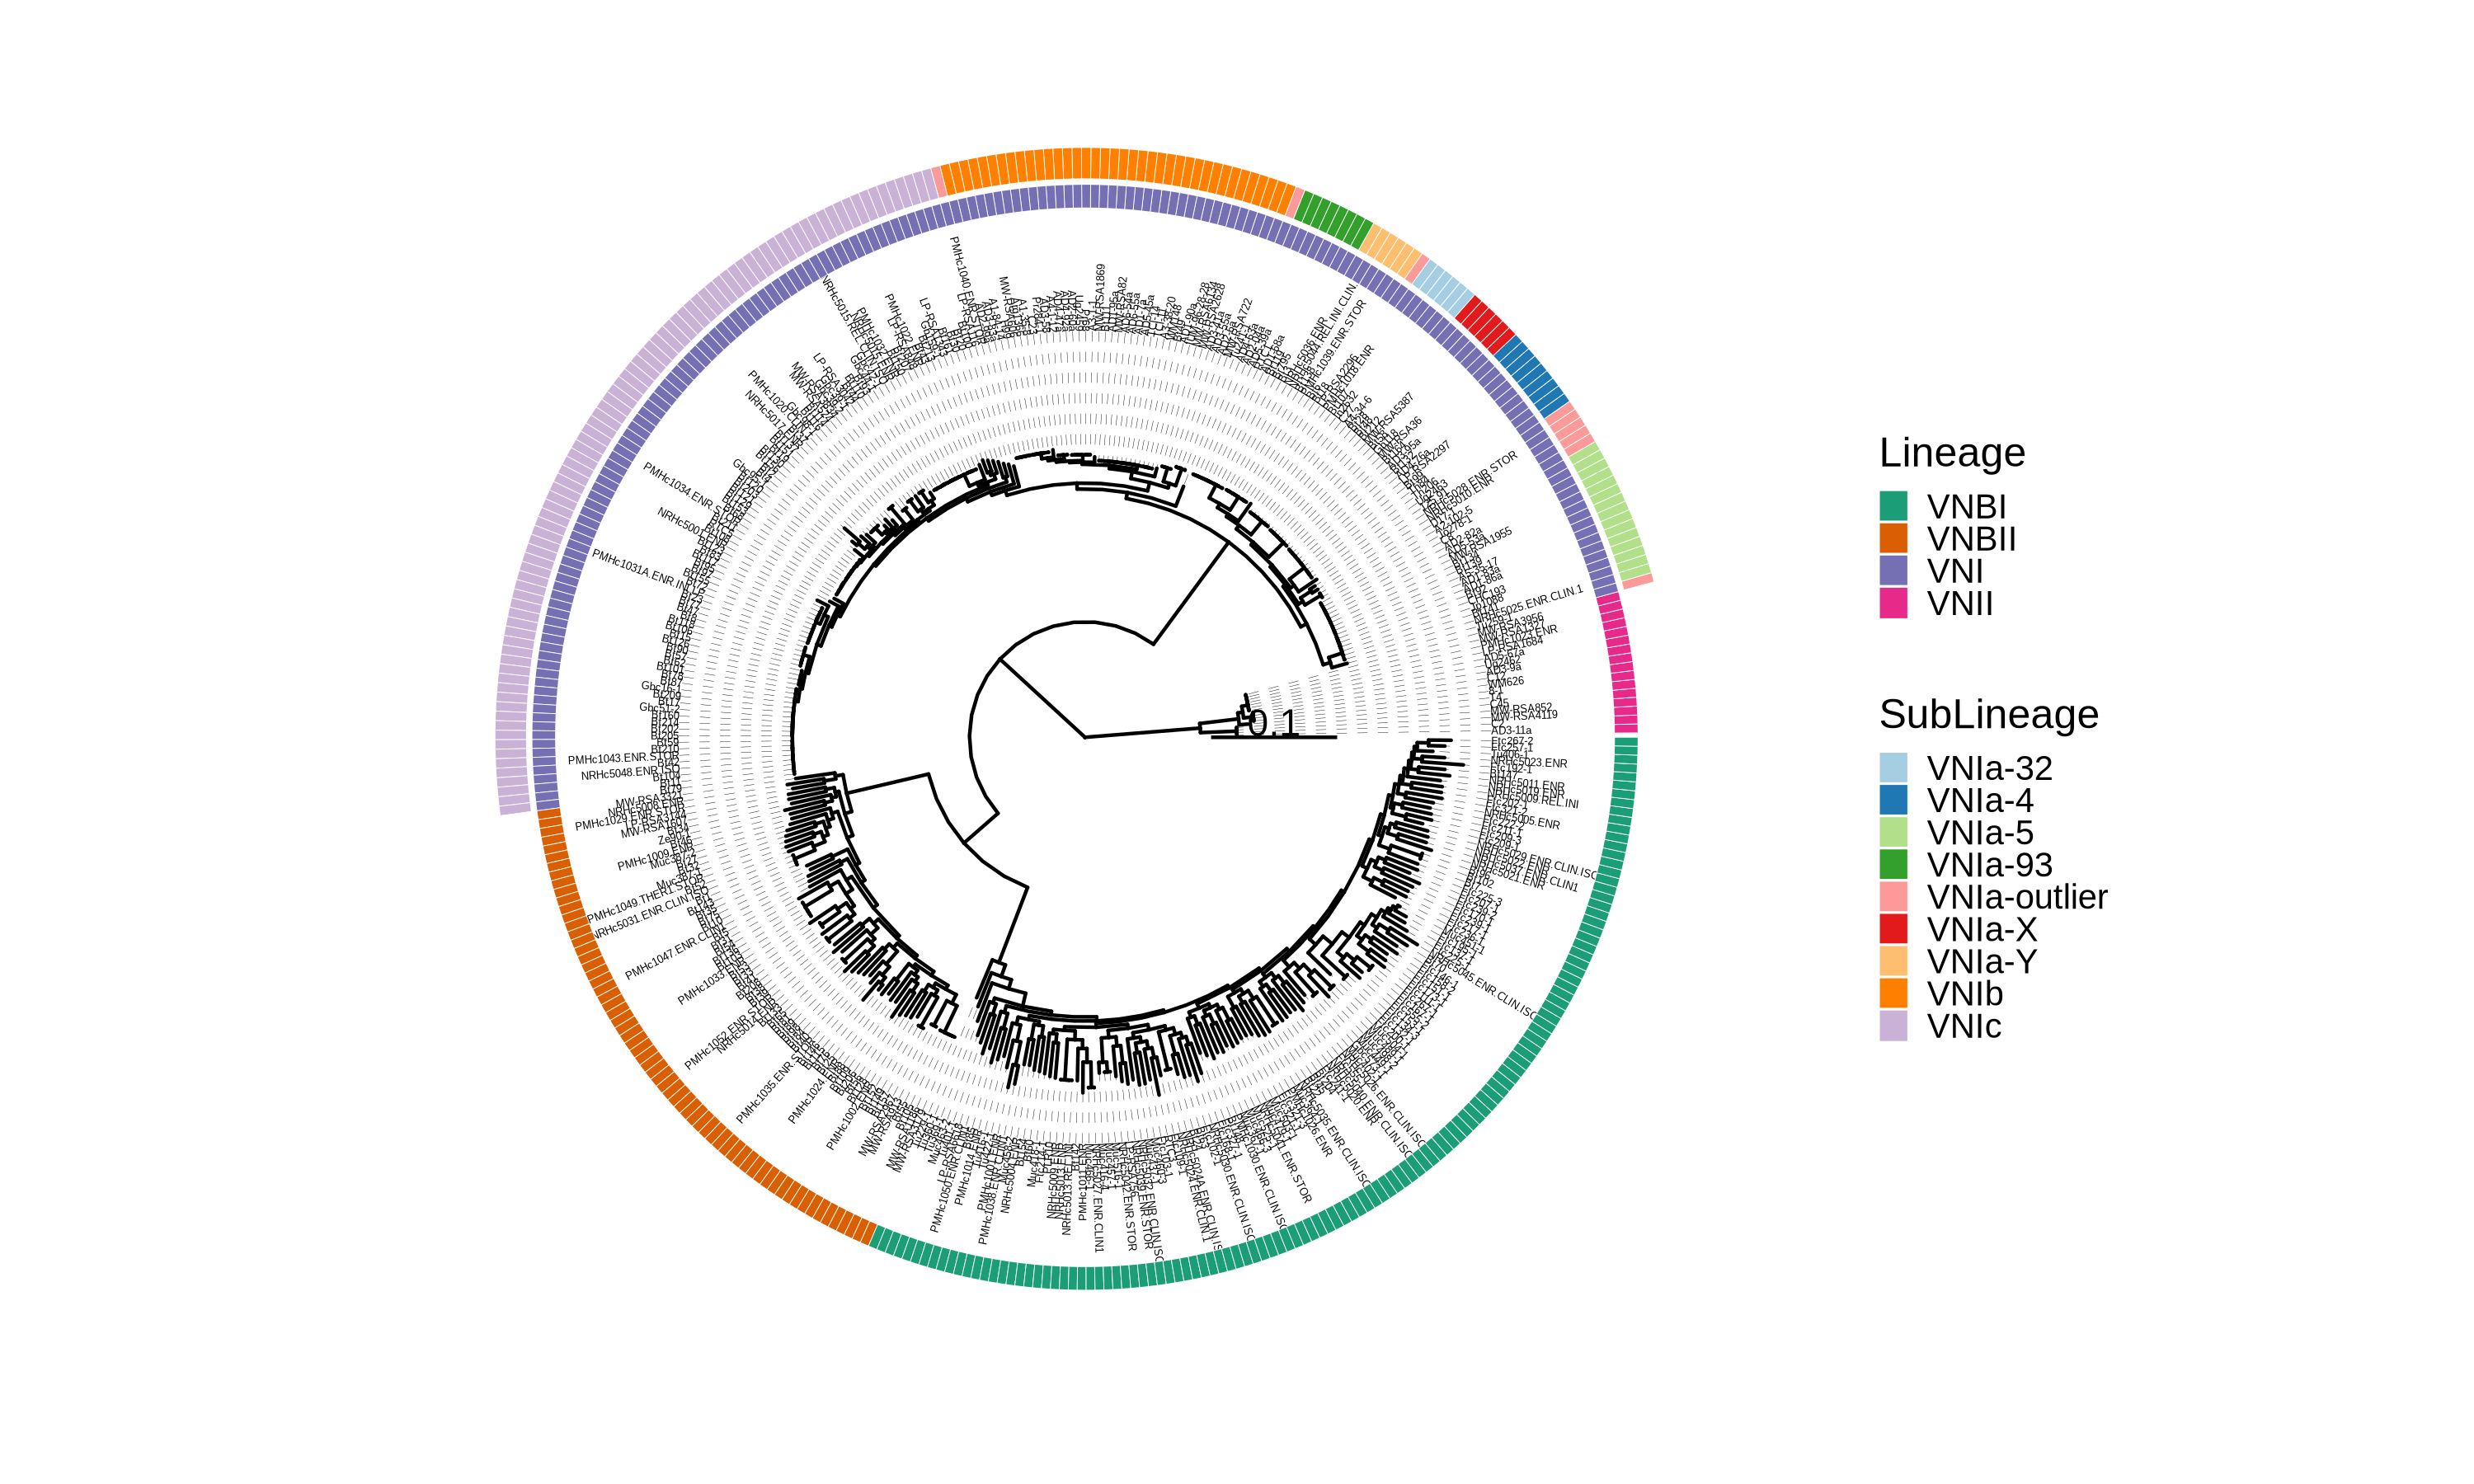

In [6]:
d <- ggtree(desj_tree, layout = "circular") +  
            geom_tiplab(aes(label = label), size = 1.1, align =TRUE, linetype = "dashed", linesize = .05, offset = 0.01)+
            geom_treescale(x=0.1, y=0, width=0.1, offset = 0.5)
d1 <- gheatmap(d, lineage, width=.06, colnames=FALSE, offset=0.1) +
            scale_fill_brewer(palette = "Dark2", name="Lineage",  na.translate = FALSE)+
            new_scale_fill()
d2 <- gheatmap(d1, sublineage, width=.08, colnames=FALSE, offset=0.12) +
            scale_fill_brewer(palette = "Paired", name="SubLineage",  na.translate = FALSE)+
        theme(legend.position = "right",
            legend.direction = "vertical",
            legend.title = element_text(size=12),
            legend.text=element_text(size=10),
            legend.key.size = unit(0.3, "cm"),
            plot.margin = margin(0, 0, 0, 0, "cm"))
                
d2

## Ashton tree

In [7]:
ashton_tree_path <- "/FastData/czirion/Crypto_Diversity_Pipeline/analyses/data/raw/2017.06.09.all_ours_and_desj.snp_sites.mod.fa.cln.tree"
ashton_tree_unrooted <- read.tree(ashton_tree_path)

Rename tips to use strains

In [8]:
ashton_tree_unrooted$tip.label <- sapply(ashton_tree_unrooted$tip.label, function(x) {
    if (x %in% metadata$run) {
        metadata$strain[metadata$run == x]
    } else {
        x
    }
})
ashton_tree_unrooted$tip.label <- sapply(ashton_tree_unrooted$tip.label, function(x) {
    if (x %in% metadata$name) {
        metadata$strain[metadata$name == x]
    } else {
        x
    }
})

Plot unrooted Ashton tree

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


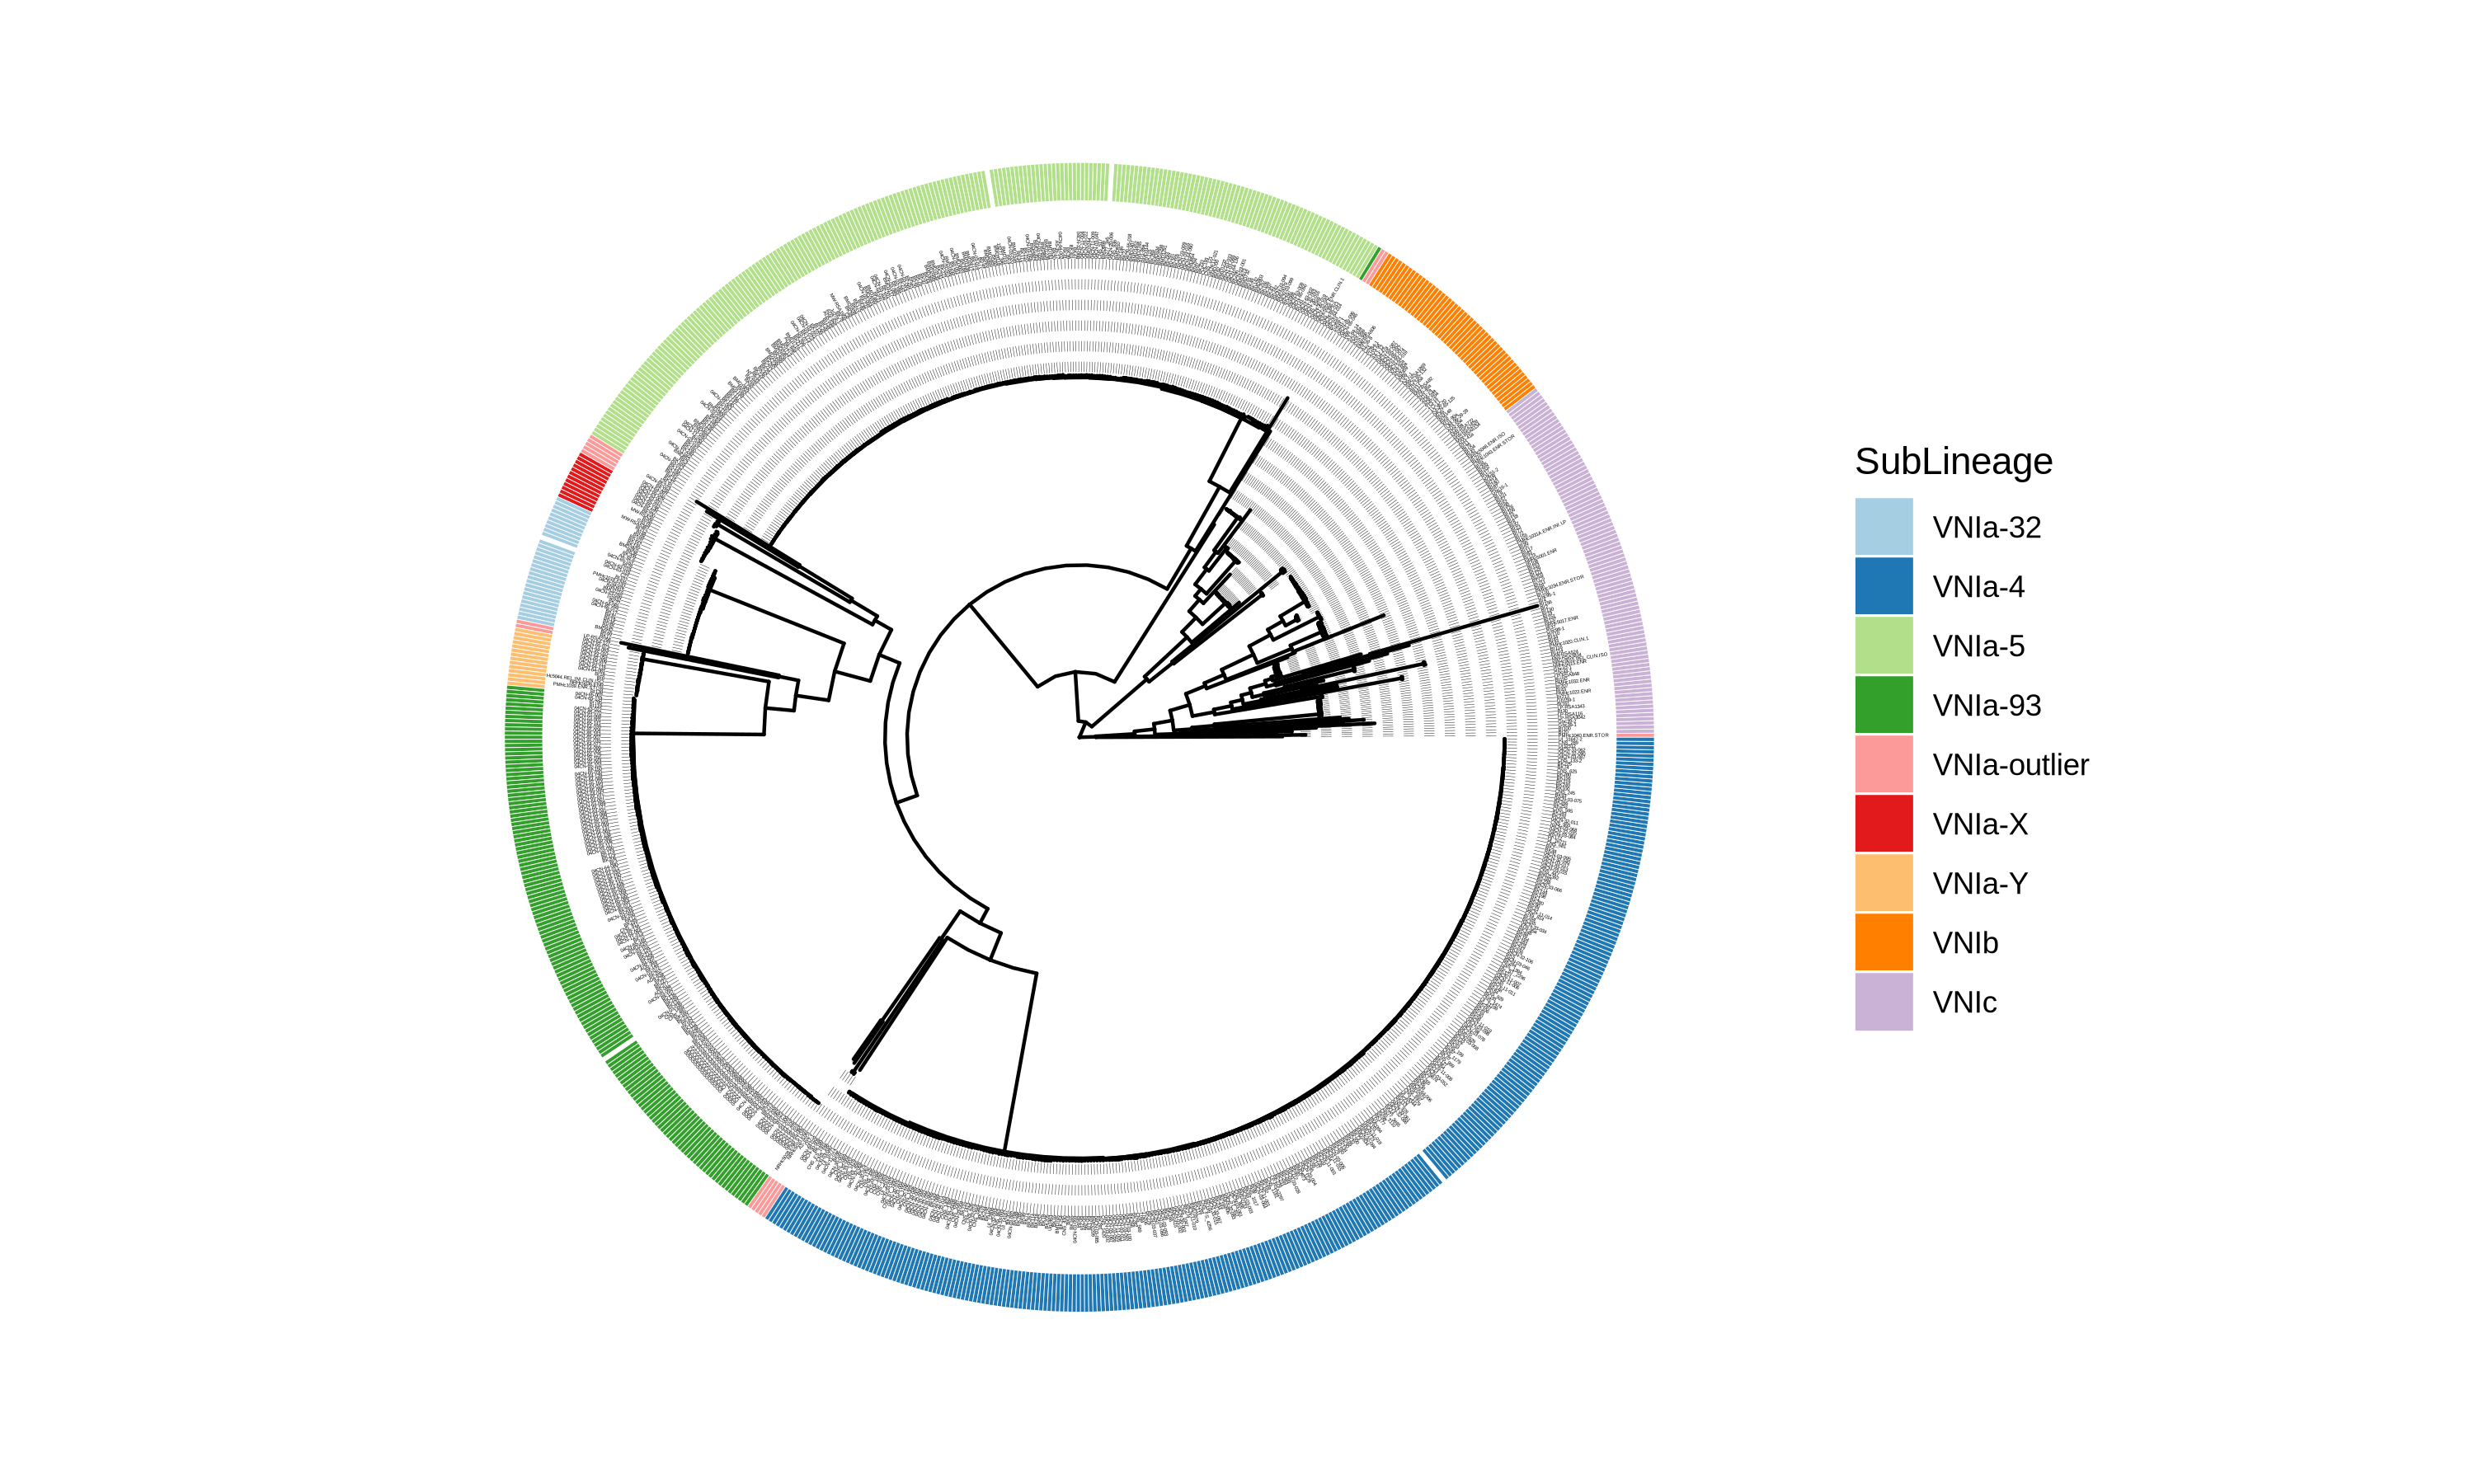

In [9]:
pu <- ggtree(ashton_tree_unrooted, layout = "circular") +  
      geom_tiplab(aes(label = label), size = 0.5, align =TRUE, linetype = "dashed", linesize = .05)
pu1 <- gheatmap(pu, sublineage, width=.08, colnames=FALSE, offset=.01) +
    scale_fill_brewer(palette = "Paired", name="SubLineage",  na.translate = FALSE)
pu1

In [10]:
# ggsave("/FastData/czirion/Crypto_Diversity_Pipeline/analyses/tree_duplications/results/figures/tree_ashton_unrooted.png", pu1, height = 10, width = 10, units = "in", dpi = 600)


Root Ashton tree at the middle of the branch leading to VNIa

In [11]:
VNIa_root <- getMRCA(ashton_tree_unrooted, c("AD3-95a","Tu259-1"))
edge_length <- subset(ashton_tree_unrooted$edge.length, ashton_tree_unrooted$edge[,2] == VNIa_root)
ashton_tree <- reroot(ashton_tree_unrooted, VNIa_root, edge_length/2)

Plot rooted Ashton tree

In [12]:
p <- ggtree(ashton_tree, layout = "circular") +  
      geom_tiplab(aes(label = label), size = 0.5, align =TRUE,linetype = "dashed", linesize = .05)
p1 <- gheatmap(p, sublineage, width=.08, colnames=FALSE, offset=.01) +
    scale_fill_brewer(palette = "Paired", name="SubLineage",  na.translate = FALSE)


Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Save plot and rooted tree file

In [13]:
# ggsave("/FastData/czirion/Crypto_Diversity_Pipeline/analyses/tree_duplications/results/figures/tree_ashton.png", p1, height = 10, width = 10, units = "in", dpi = 600)
# write.tree(ashton_tree, file = "/FastData/czirion/Crypto_Diversity_Pipeline/analyses/data/processed/ashton_tree.newick")

Plot a rectangular version

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


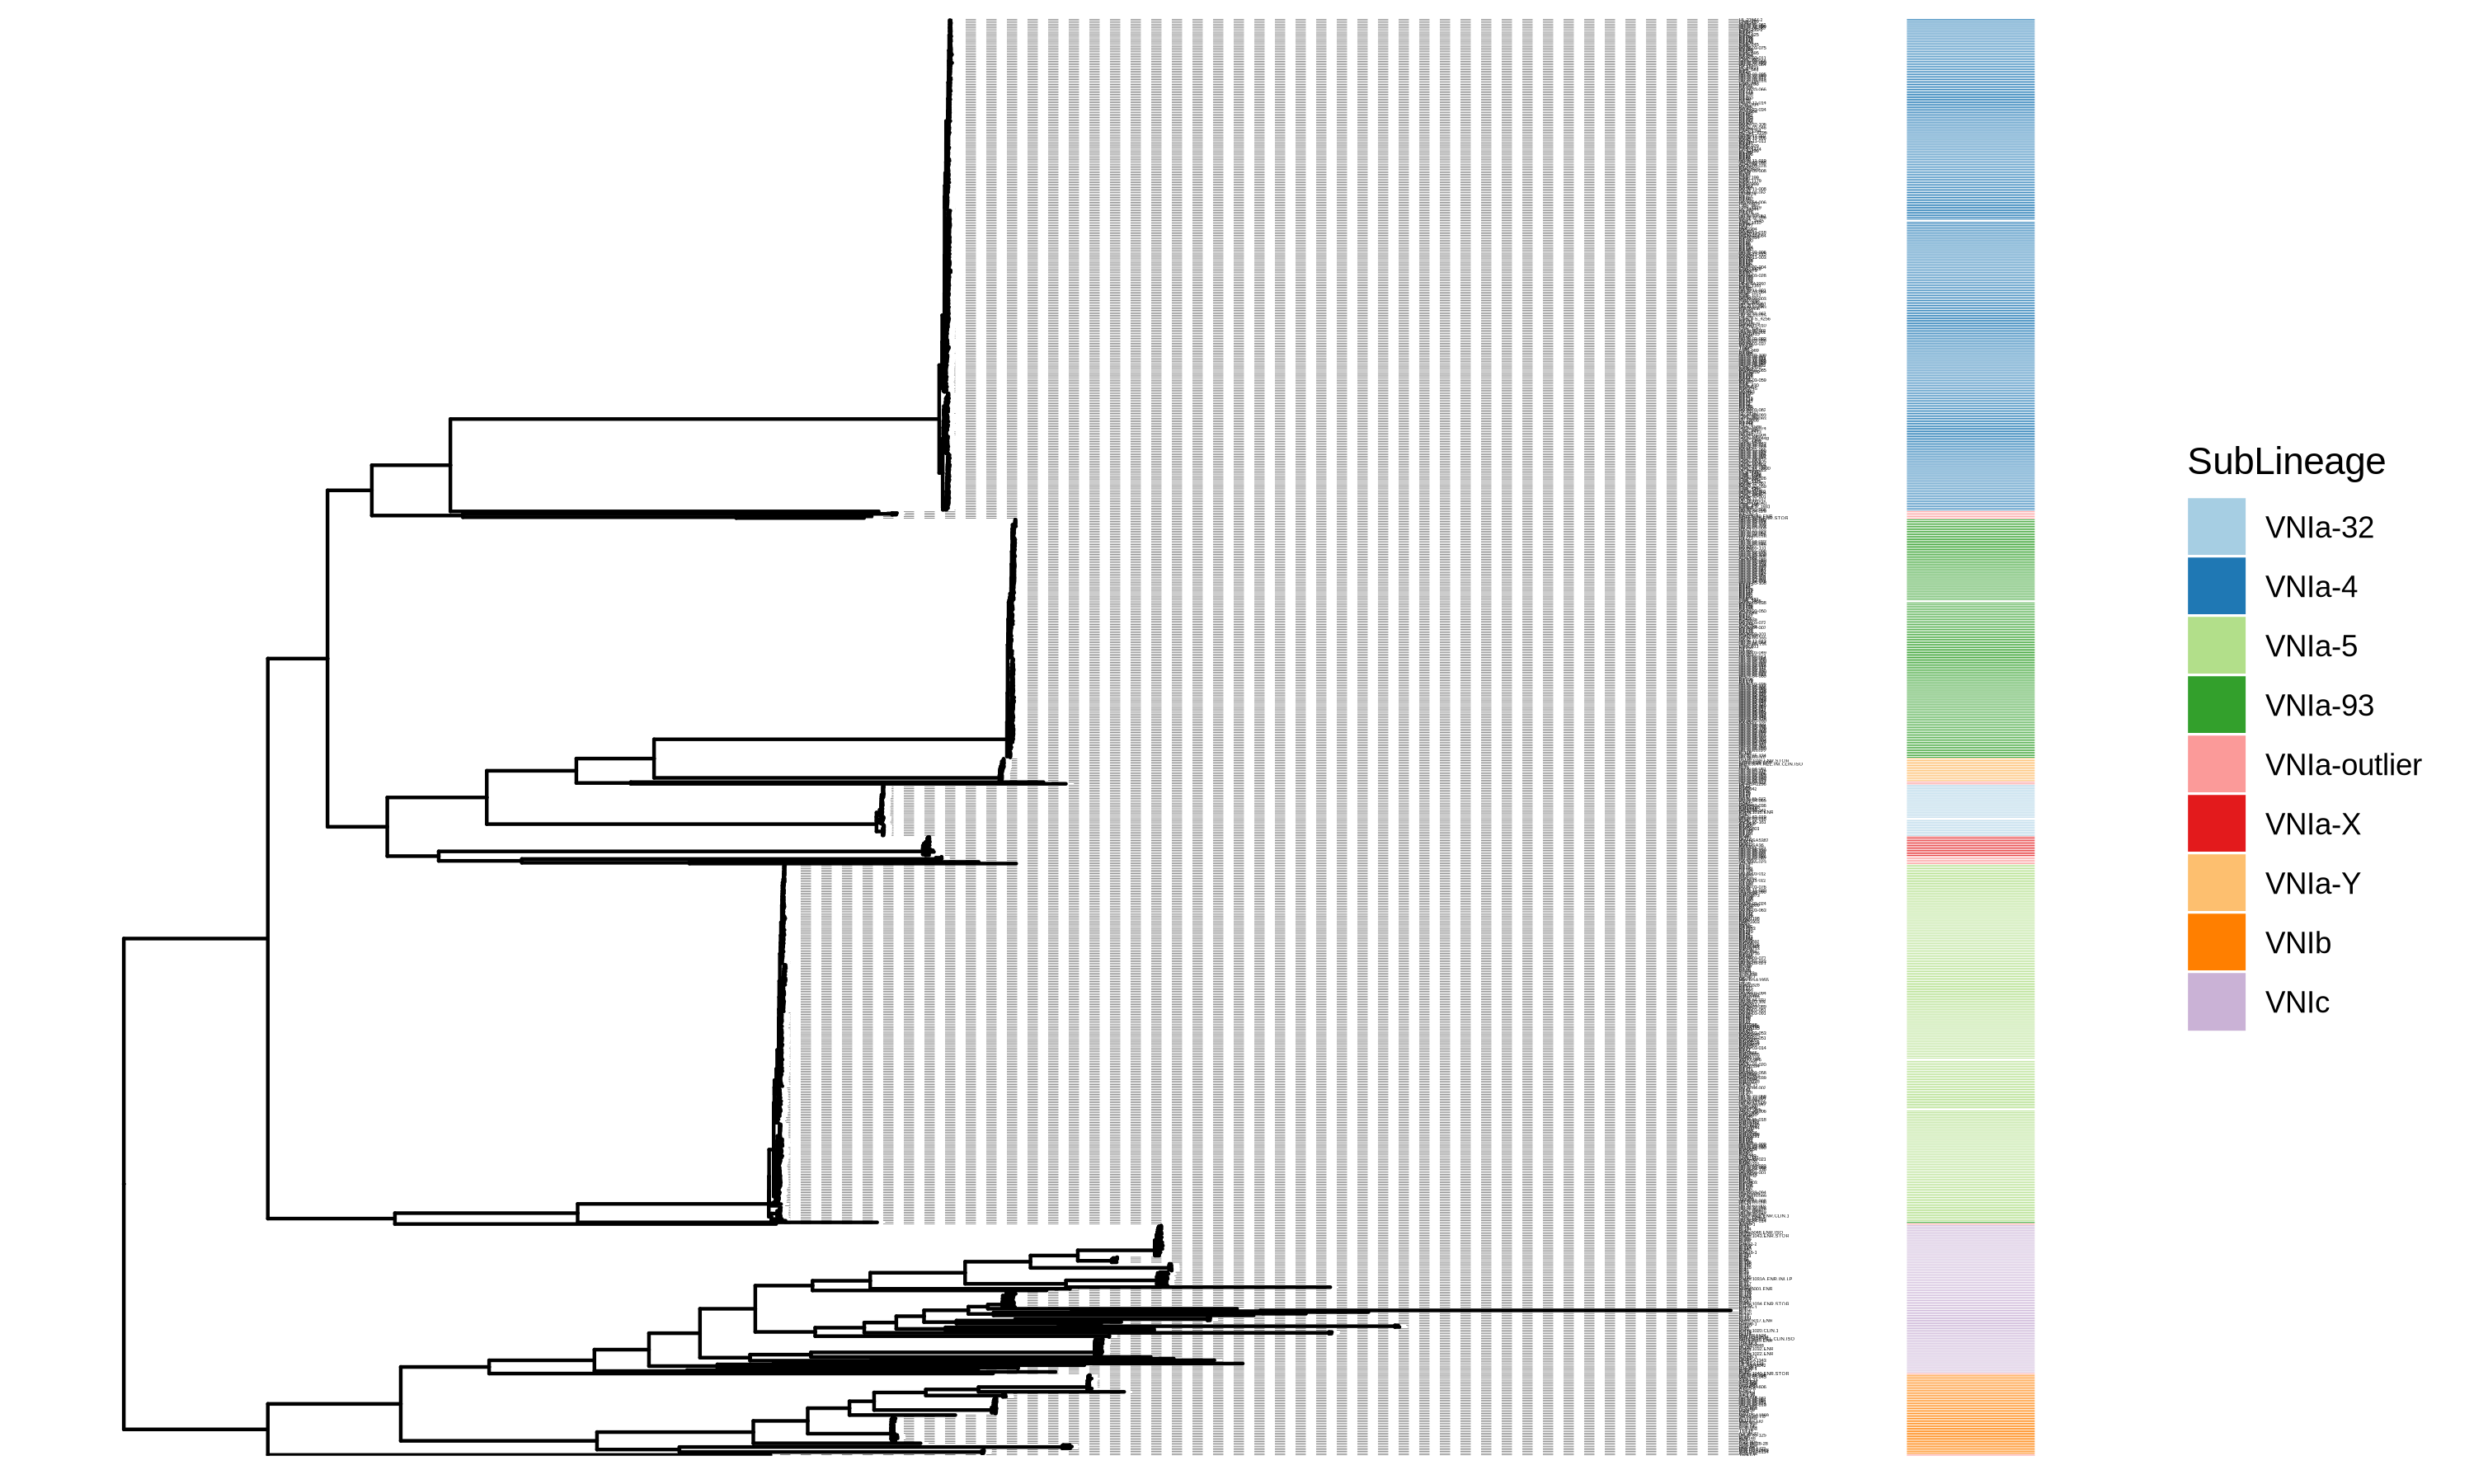

In [14]:

ashton_tree <- read.tree("/FastData/czirion/Crypto_Diversity_Pipeline/analyses/data/processed/ashton_tree.newick")
p <- ggtree(ashton_tree, layout = "rectangular") +  
      geom_tiplab(aes(label = label), size = 0.5, align =TRUE,linetype = "dashed", linesize = .05)
p1 <- gheatmap(p, sublineage, width=.08, colnames=FALSE, offset=.01) +
    scale_fill_brewer(palette = "Paired", name="SubLineage",  na.translate = FALSE)
p1

Save the rectangular plot

In [15]:
# ggsave("/FastData/czirion/Crypto_Diversity_Pipeline/analyses/tree_duplications/results/figures/tree_ashton_rectangular.pdf", p1, height = 10, width = 10, units = "in", dpi = 600)

## Merge the Desjardins and Ashton trees

Specify clades in the Desjardins tree

In [16]:
VNI <- c("Bt92", "Bt79")
VNI_node <- getMRCA(desj_tree, VNI)
VNII <- c("C2","C12")
VNII_node <- getMRCA(desj_tree, VNII)
VNB <- c("Bt7", "Bt34")
VNB_node <- getMRCA(desj_tree, VNB)

Get the ages of the nodes from the original Desjardins tree

In [17]:
edge_lengths <- node.depth.edgelength(desj_tree)
node_labels <- c(desj_tree$tip.label, desj_tree$node.label)
edge_length_mapping <- data.frame(node = node_labels, edge_length = edge_lengths, max_length = max(edge_lengths))
edge_length_mapping <- edge_length_mapping %>% 
                        mutate(age = max_length - edge_length) %>%
                        rownames_to_column("node_id")
clade_ages <- edge_length_mapping %>% 
                filter(node_id %in% c(VNI_node, VNII_node, VNB_node))
nodeages <- c("Bt92-Bt79" = clade_ages$age[clade_ages$node_id == VNI_node],
             "C2-C12" = clade_ages$age[clade_ages$node_id == VNII_node],
             "Bt7-Bt34" = clade_ages$age[clade_ages$node_id == VNB_node])
tip_ages <- edge_length_mapping %>% 
                filter(node %in% metadata$strain)
tipages <- tip_ages$age
names(tipages) <- tip_ages$node

Remove VNI clade from Desjardins tree to use it as backtree

In [18]:
VNI_tips <- tips(desj_tree, VNI_node)
backtree <- drop.tip(desj_tree, VNI_tips)

Create the reference tables

In [19]:
reference <- data.frame(bind=c("CNS_289-BK8"),
                   reference=c("Bt7-Bt34"), # "H99"
                   poly=c(FALSE))


Merge the trees

In [20]:
merged <- tree.merger(backbone = backtree,
                        data=reference,
                        source.tree = ashton_tree,
                        plot=FALSE,
                        node.ages = nodeages,
                        tip.ages = tipages)

  |======================================================================| 100%


Binding done!



  |===================================================================== |  99%


Warning message:
“Age Calibration failed with the error: 
Error in scaleTree(tree, node.ages = node.ages, tip.ages = tip.ages) : 
  The age for 1072 cannot be older than the age indicated for 1071

 Returning the uncalibrated version of the tree”


Write the merged tree to file

In [21]:
# write.tree(merged, file = "/FastData/czirion/Crypto_Diversity_Pipeline/analyses/data/processed/merged_tree.newick")

Plot merged tree with branchlengths (although they are not meaningful)

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


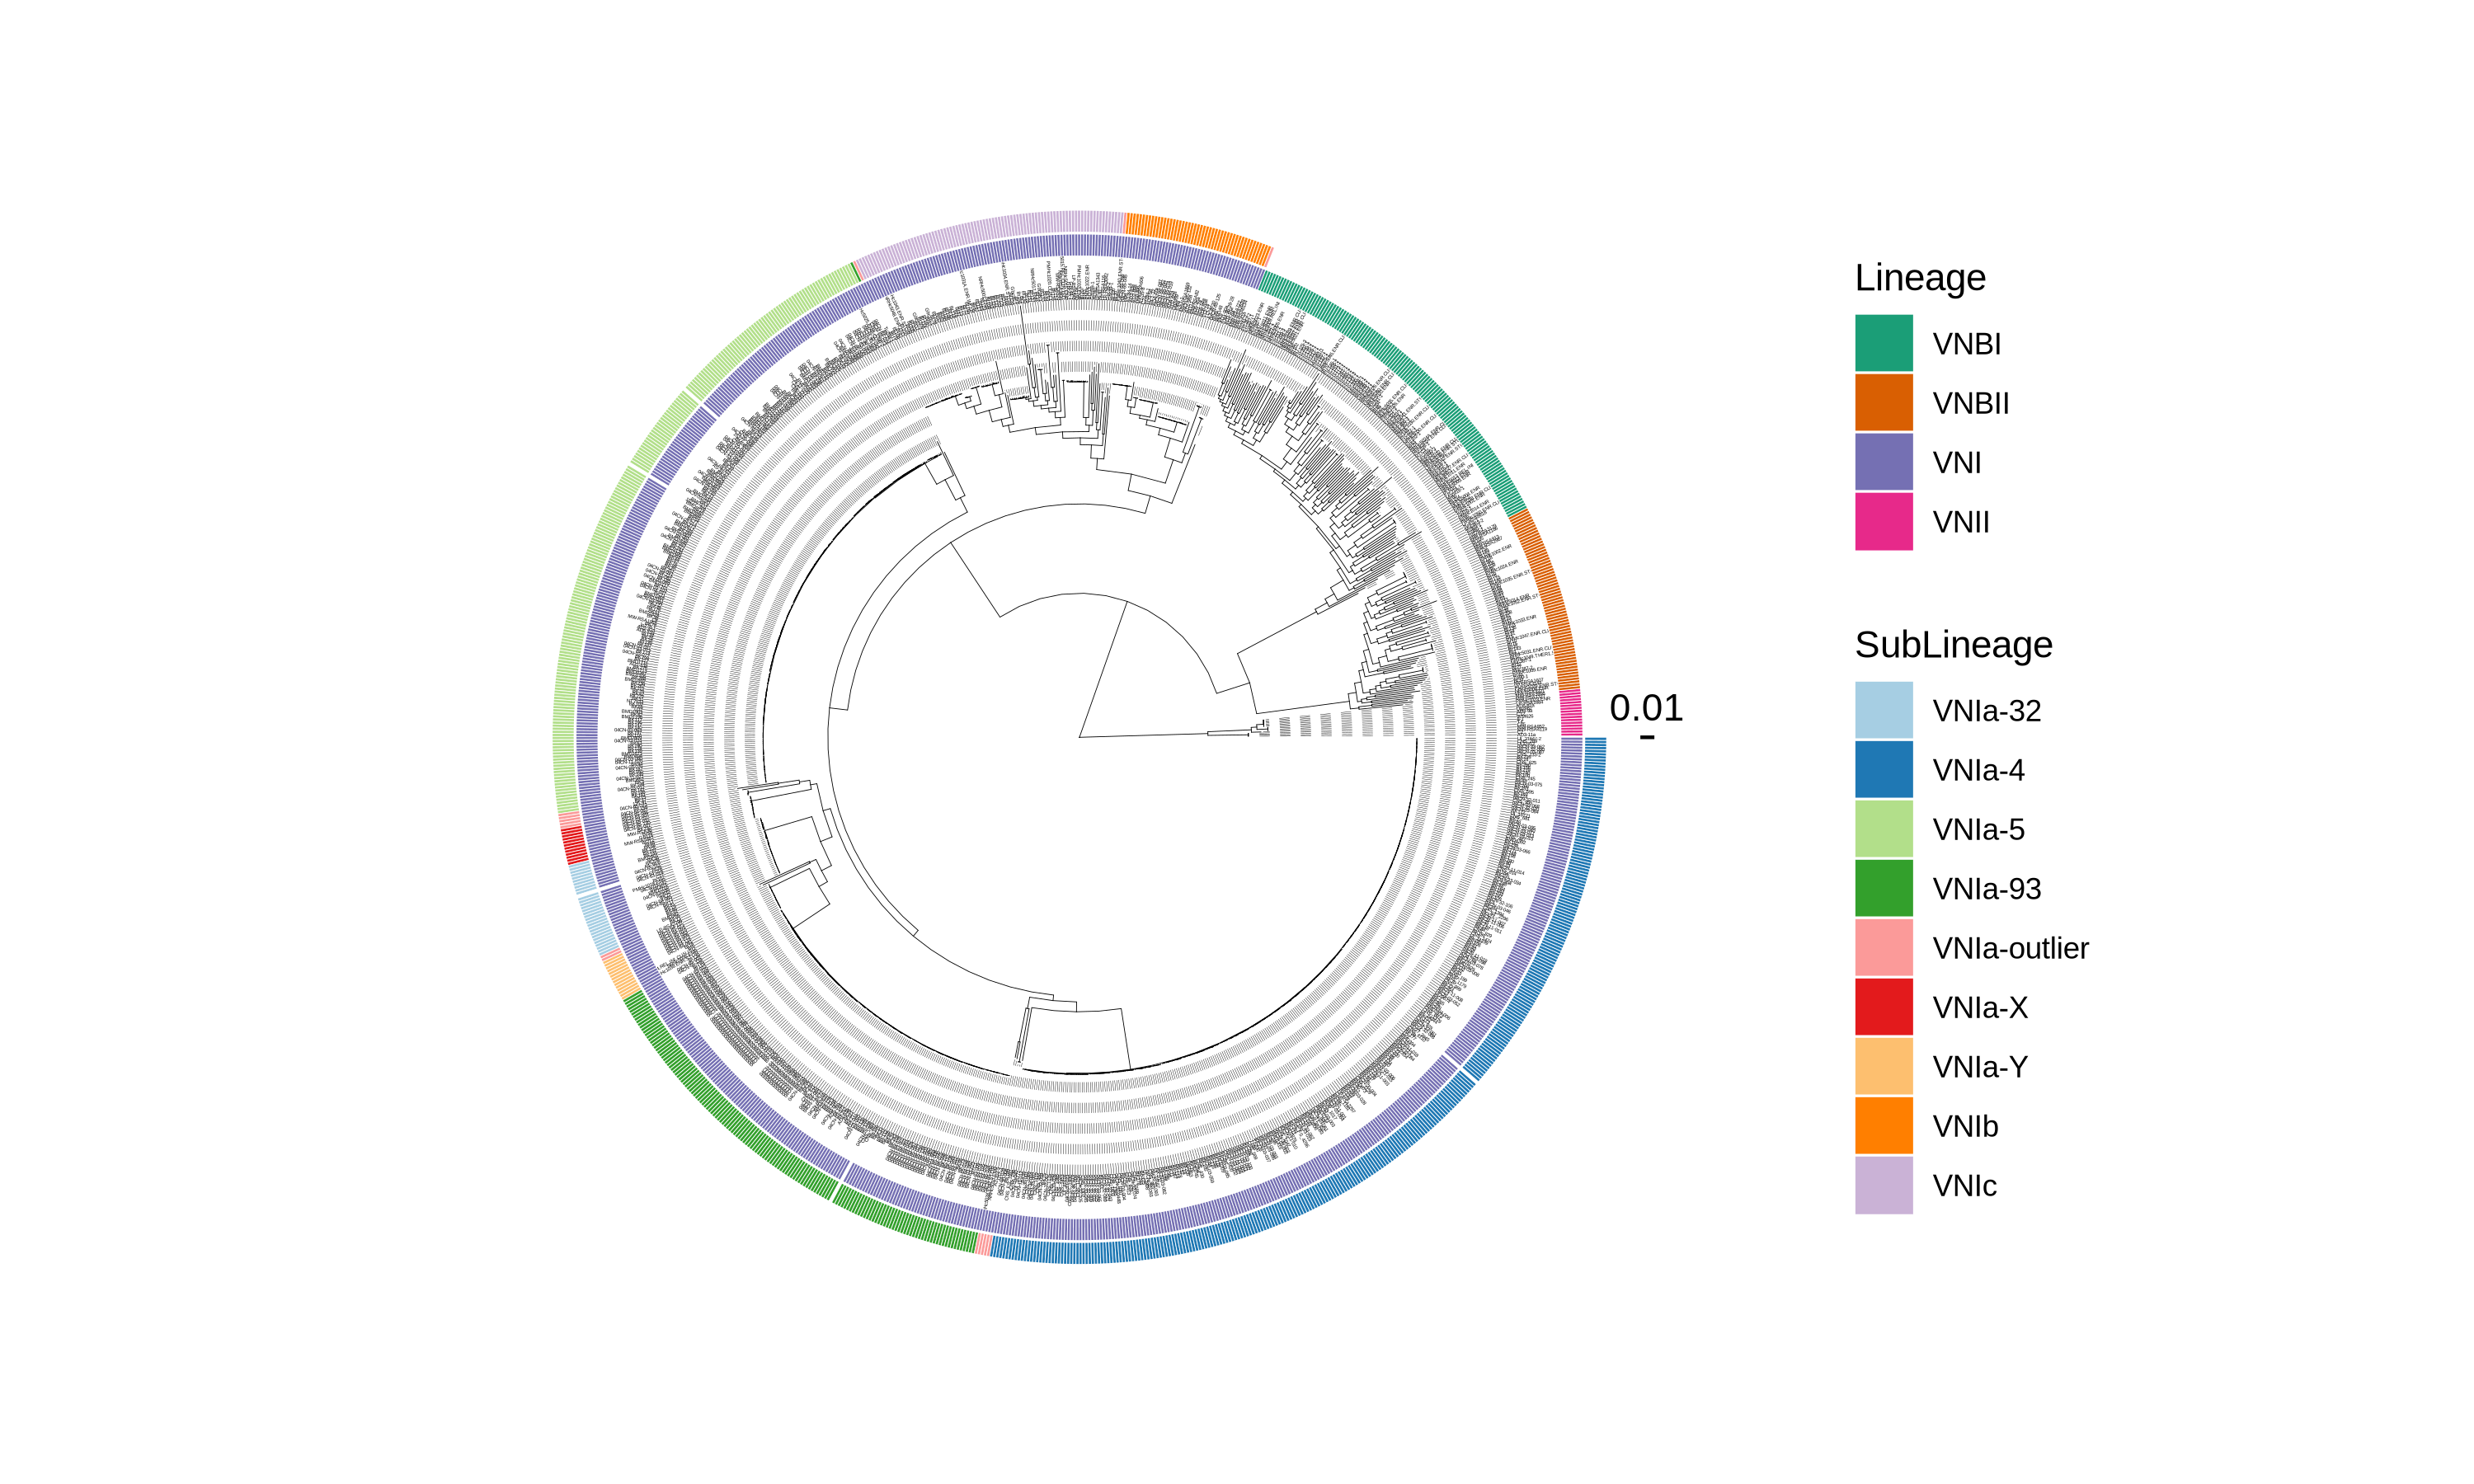

In [22]:
p <- ggtree(merged, layout = "circular", size = 0.1) +  
      geom_tiplab(aes(label = label), size = 0.5, align =TRUE, 
                    linetype = "dashed", linesize = .05)+
    geom_treescale(x=0.4, y=0, width=0.01, offset = 5)

m1 <- gheatmap(p, lineage, width=.05, colnames=FALSE, offset=.025) +
    scale_fill_brewer(palette = "Dark2", name="Lineage",  na.translate = FALSE)+
    new_scale_fill()

m2 <- gheatmap(m1, sublineage, width=.05, colnames=FALSE, offset=.042) +
    scale_fill_brewer(palette = "Paired", name="SubLineage",  na.translate = FALSE)
m2

Write plot to file

In [23]:
# ggsave("/FastData/czirion/Crypto_Diversity_Pipeline/analyses/tree_duplications/results/figures/tree_merged_branchlengths.png", m2, height = 10, width = 10, units = "in", dpi = 600)

Plot the merged tree without branchlengths

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


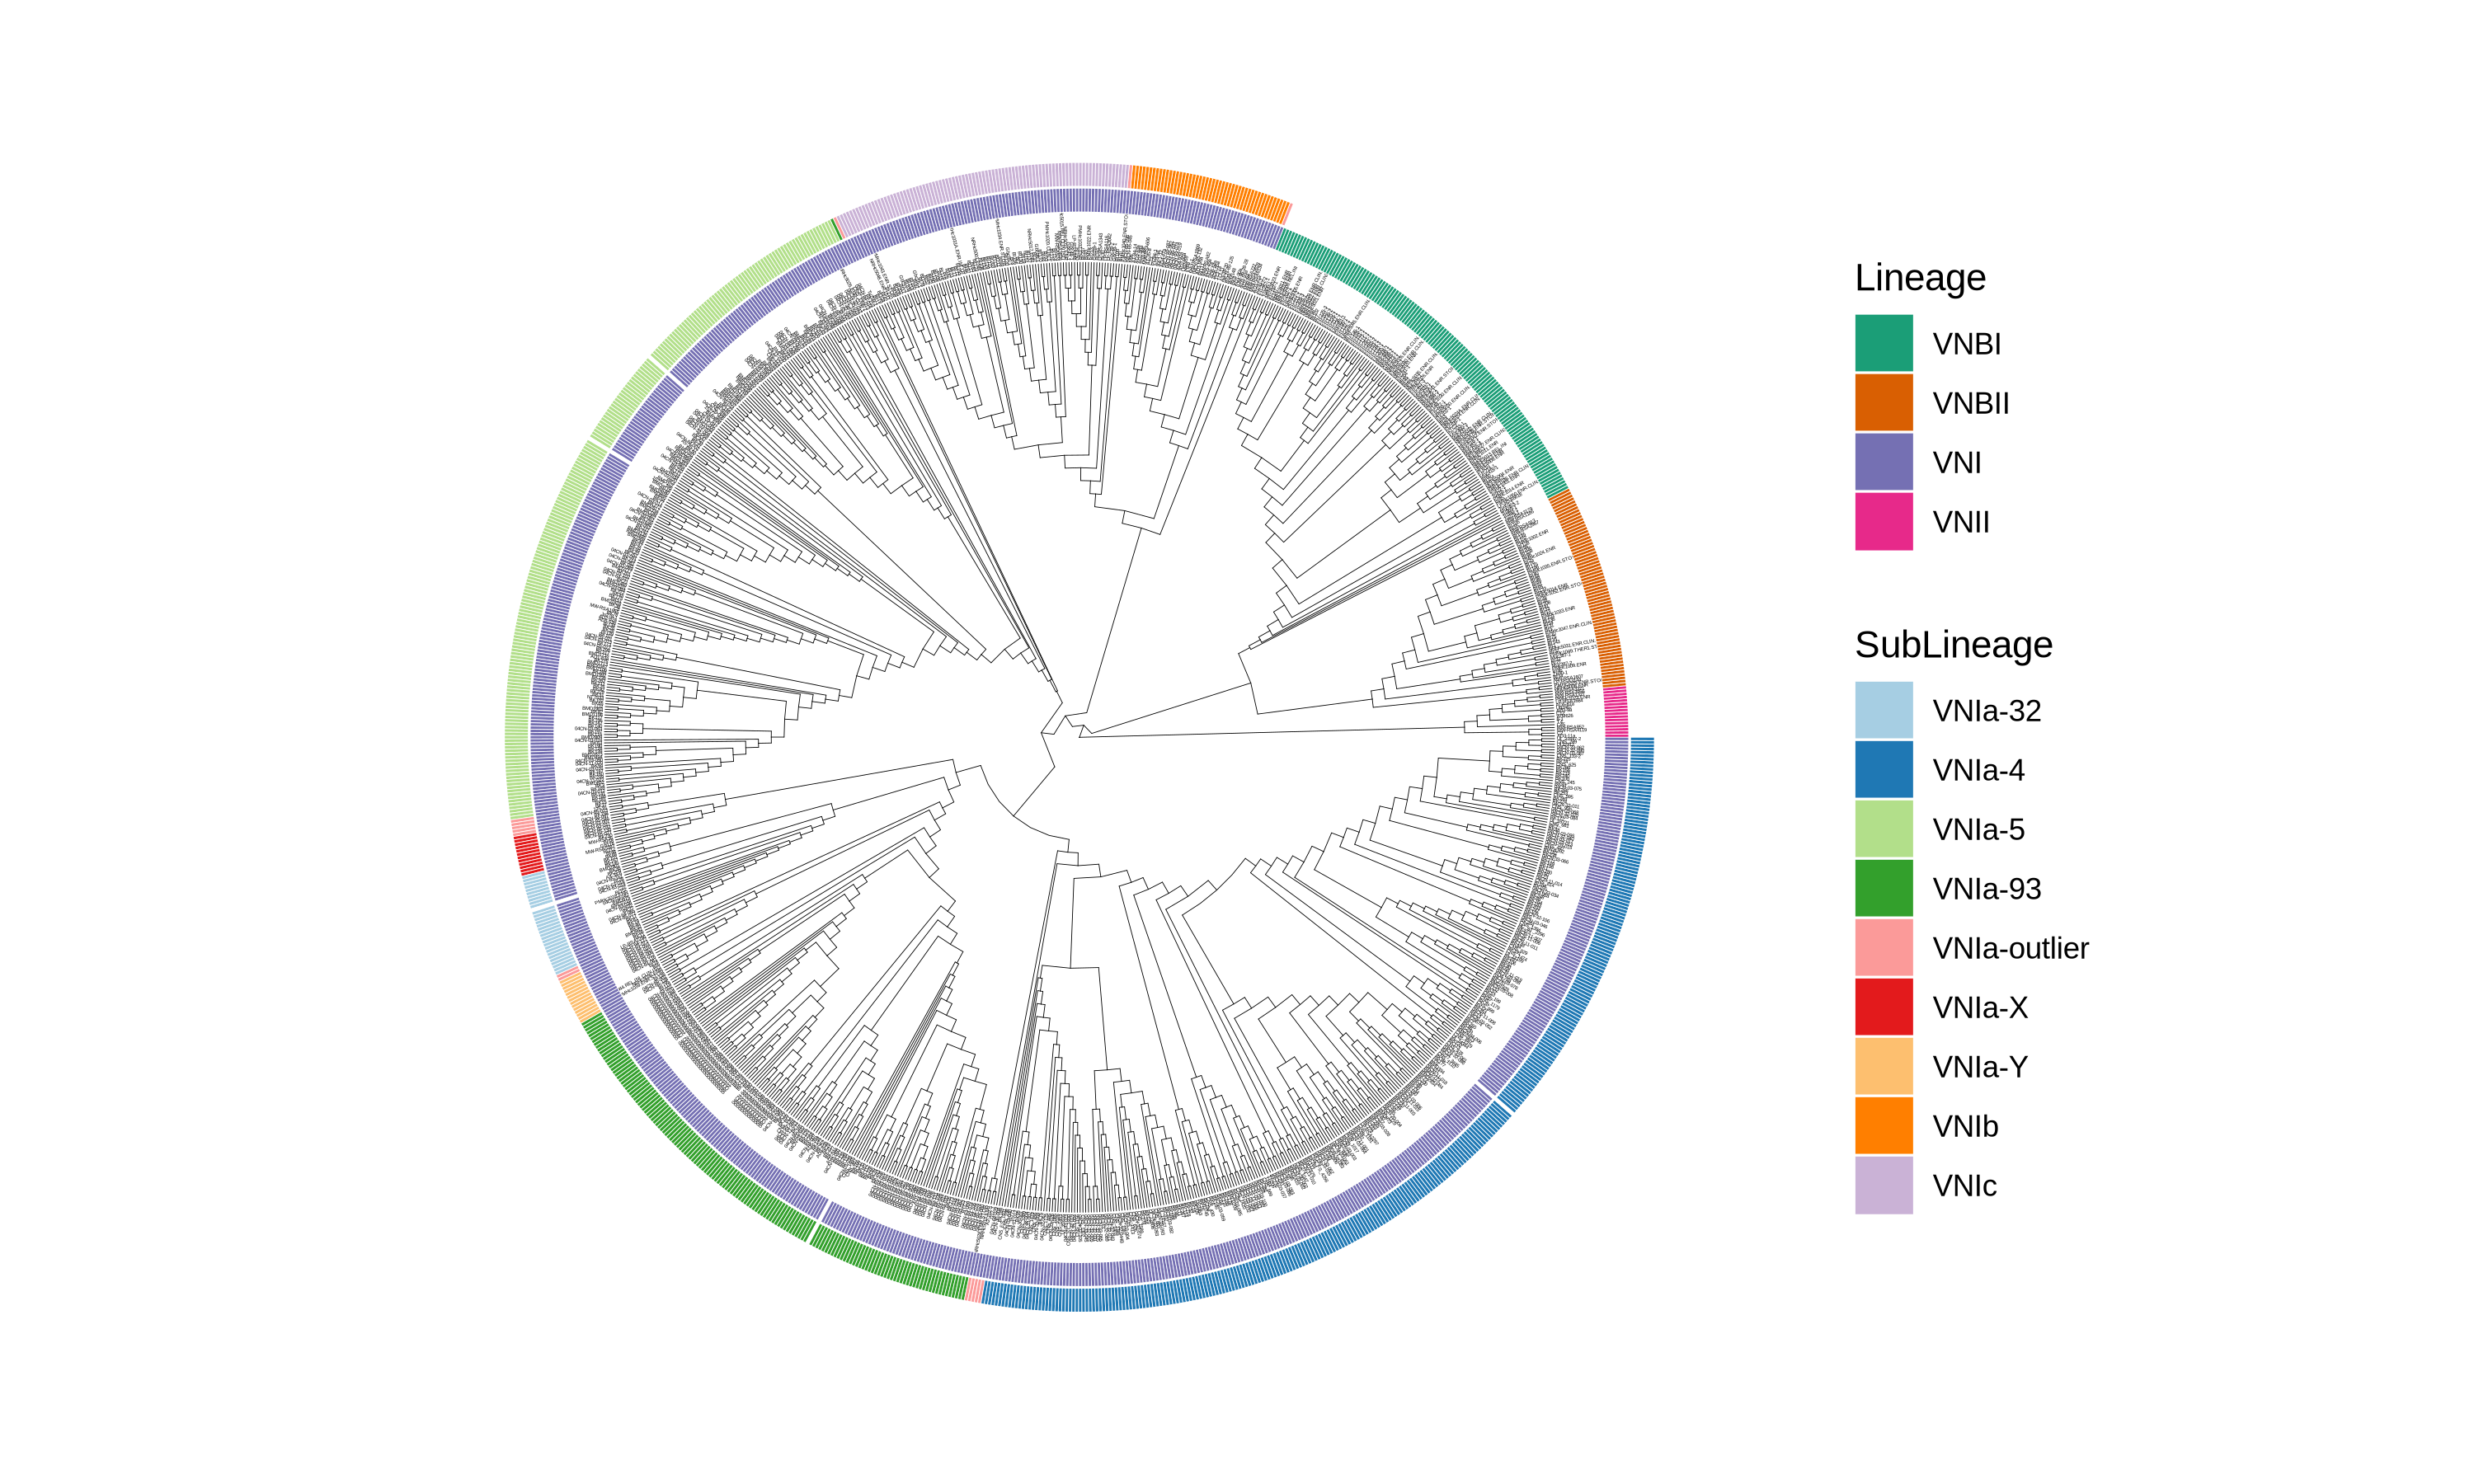

In [24]:
p <- ggtree(merged, layout = "circular", size = 0.1, branch.length = "none") +  
      geom_tiplab(aes(label = label), size = 0.5, align =TRUE, 
                    linetype = "dashed", linesize = .05)

m1 <- gheatmap(p, lineage, width=.05, colnames=FALSE, offset=3) +
    scale_fill_brewer(palette = "Dark2", name="Lineage",  na.translate = FALSE)+
    new_scale_fill()

m2 <- gheatmap(m1, sublineage, width=.05, colnames=FALSE, offset=5) +
    scale_fill_brewer(palette = "Paired", name="SubLineage",  na.translate = FALSE)
m2


Write the cladogram of the merged tree to file

In [25]:
# ggsave("/FastData/czirion/Crypto_Diversity_Pipeline/analyses/tree_duplications/results/figures/tree_merged.png", m2, height = 10, width = 10, units = "in", dpi = 600)

In [26]:
VNI <- metadata %>%
    filter(lineage == "VNI", vni_subdivision != "VNIa-outlier") %>%
    group_by(vni_subdivision) %>%
    slice(1) %>%
    ungroup()
VNIa_outlier <- metadata %>%
    filter(vni_subdivision == "VNIa-outlier")
VNII <- metadata %>%
    filter(lineage == "VNII") %>%
    slice(1) %>%
    ungroup()
VNBI <- metadata %>%
    filter(lineage == "VNBI") %>%
    slice(1) %>%
    ungroup()
VNBII <- metadata %>%
    filter(lineage == "VNBII") %>%
    slice(1) %>%
    ungroup()
tips <- rbind(VNI, VNIa_outlier, VNII, VNBI, VNBII)%>%
    select(strain)

Make a small version of the merged tree only with the tips in `tips`

In [27]:
small_tree <- drop.tip(merged, setdiff(merged$tip.label, tips$strain))

Plot the small tree

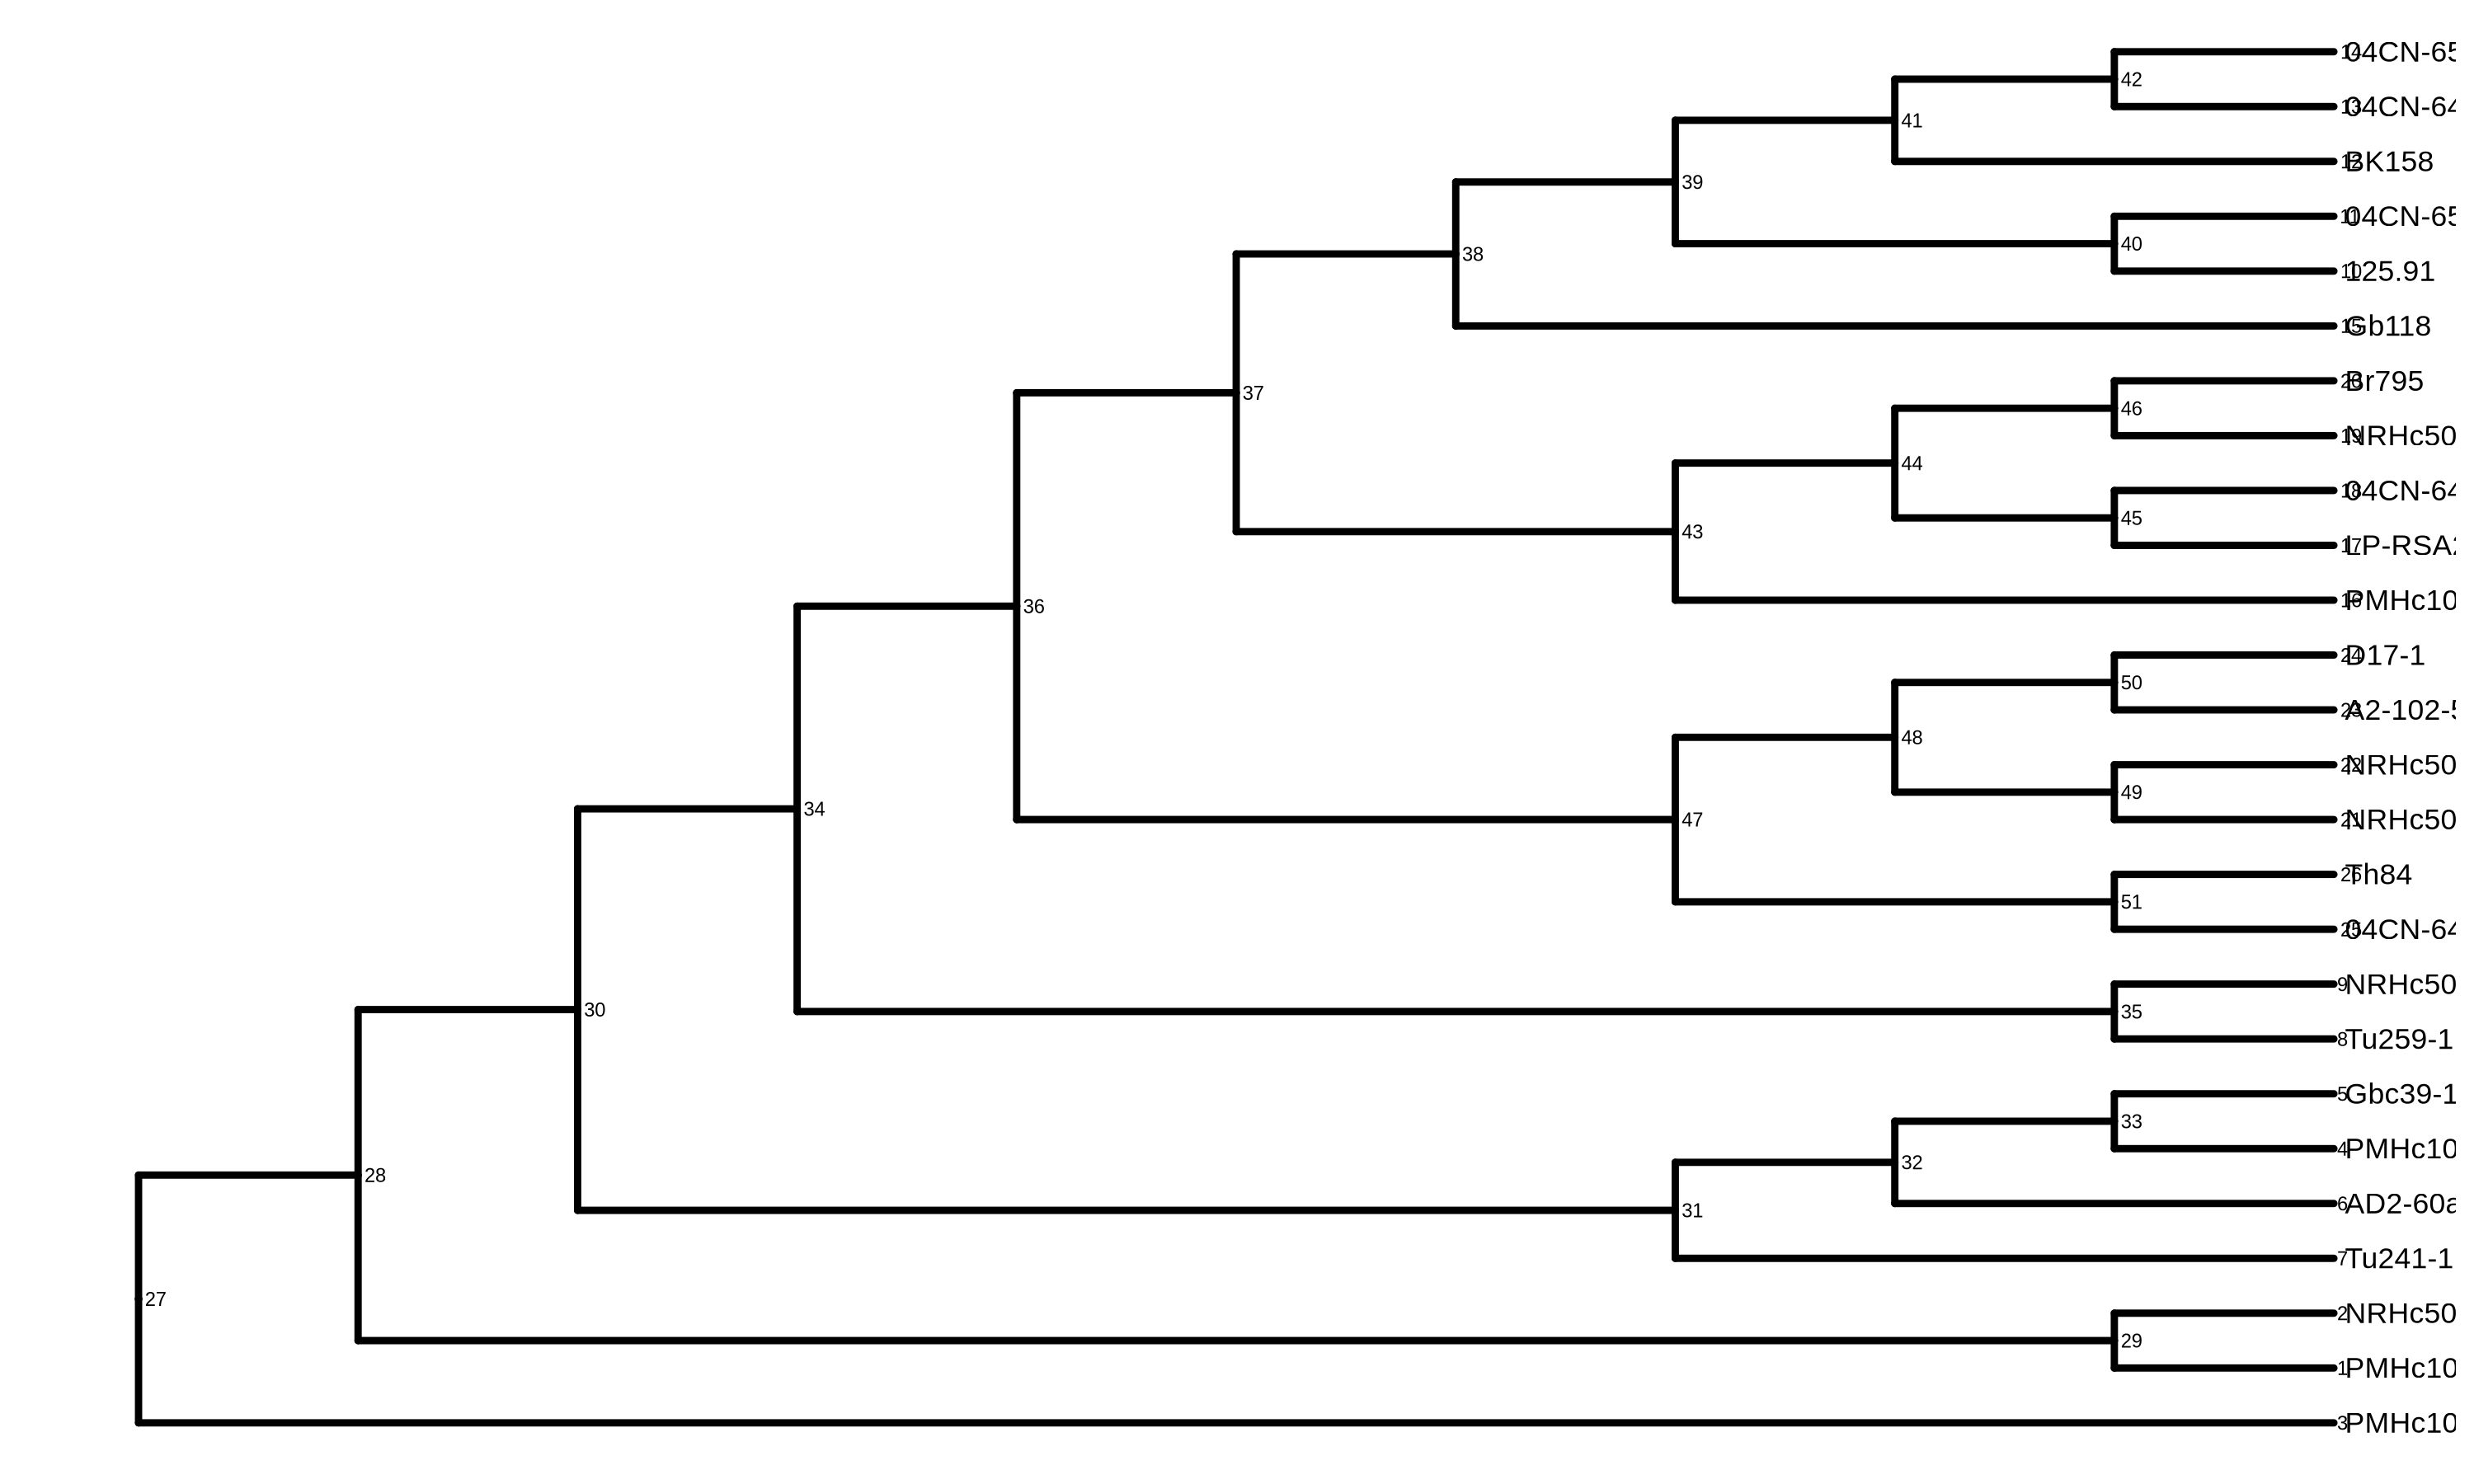

In [28]:
p <- ggtree(small_tree, layout = "rectangular", size = 1, branch.length = "none") +  
    geom_tiplab(aes(label = label), size = 3, align = TRUE, 
                linetype = "dashed", linesize = .05) +
    geom_text(aes(label = node), hjust = -0.3, size = 2) 
    p

In [ ]:
p <- ggtree(small_tree, layout = "rectangular", size = 1, branch.length = "none", aes(color = sublineage[small_tree$tip.label])) +  
    geom_tiplab(aes(label = label), size = 3, align = TRUE, 
                linetype = "dashed", linesize = .05) +
    scale_color_brewer(palette = "Paired", name = "SubLineage", na.translate = FALSE)

p1 <- gheatmap(p, lineage, width = .05, colnames = FALSE, offset = 3) +
    scale_fill_brewer(palette = "Dark2", name = "Lineage", na.translate = FALSE) +
    new_scale_fill()

p2 <- gheatmap(p1, sublineage, width = .05, colnames = FALSE, offset = 3.5) +
    scale_fill_brewer(palette = "Paired", name = "SubLineage", na.translate = FALSE)

p2

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
ERROR while rich displaying an object: Error in `stat_tree()`:
! Problem while computing aesthetics.
ℹ Error occurred in the 1st layer.
Caused by error in `[.data.frame`:
! undefined columns selected

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No 